## Import required libraries

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn
from math import sqrt

In [88]:
## Import historical data 

In [155]:
from help_functions import get_energy_data

energy_data = get_energy_data.get_data(
    'hourly_ec_20201107_20231107.csv')
energy_data

,date,beginning,end,energy_consumption
date_time,,,,
2020-11-07 00:00:00,2020-11-07,00:00:00,01:00:00,46.97475
2020-11-07 01:00:00,2020-11-07,01:00:00,02:00:00,45.35550
2020-11-07 02:00:00,2020-11-07,02:00:00,03:00:00,44.66450
2020-11-07 03:00:00,2020-11-07,03:00:00,04:00:00,44.76300
2020-11-07 04:00:00,2020-11-07,04:00:00,05:00:00,44.81150
...,...,...,...,...
2023-11-07 06:00:00,2023-11-07,06:00:00,07:00:00,59.43725
2023-11-07 07:00:00,2023-11-07,07:00:00,08:00:00,63.89000
2023-11-07 08:00:00,2023-11-07,08:00:00,09:00:00,66.64725


In [156]:
# add weekdays and starting hours 
energy_data['weekday'] = energy_data.index.weekday  # monday = 0, sunday = 6
energy_data['hour'] = energy_data.index.hour
energy_data['month'] = energy_data.index.month
energy_data.head()

,date,beginning,end,energy_consumption,weekday,hour,month
date_time,,,,,,,
2020-11-07 00:00:00,2020-11-07,00:00:00,01:00:00,46.97475,5,0,11
2020-11-07 01:00:00,2020-11-07,01:00:00,02:00:00,45.35550,5,1,11
2020-11-07 02:00:00,2020-11-07,02:00:00,03:00:00,44.66450,5,2,11
2020-11-07 03:00:00,2020-11-07,03:00:00,04:00:00,44.76300,5,3,11
2020-11-07 04:00:00,2020-11-07,04:00:00,05:00:00,44.81150,5,4,11


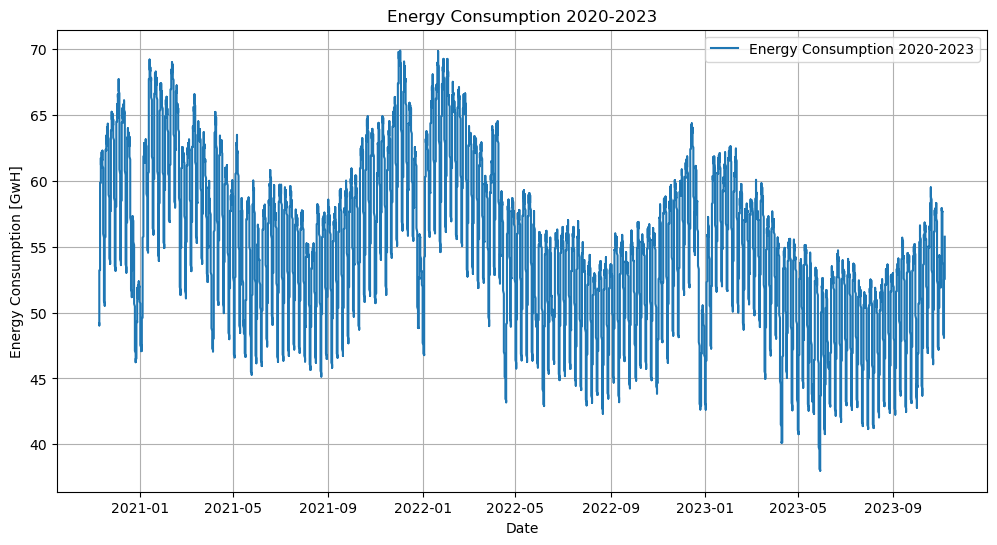

In [117]:
window_size = 50  # Adjust as needed
energy_data['smoothed'] = energy_data['energy_consumption'].rolling(window=window_size).mean()

plt.figure(figsize=(12, 6))
plt.plot(energy_data['date'], energy_data['smoothed'], label='Energy Consumption 2020-2023')
plt.xlabel('Date')
plt.ylabel('Energy Consumption [GwH]')
plt.title('Energy Consumption 2020-2023')
plt.legend()
plt.grid(True)
plt.show()

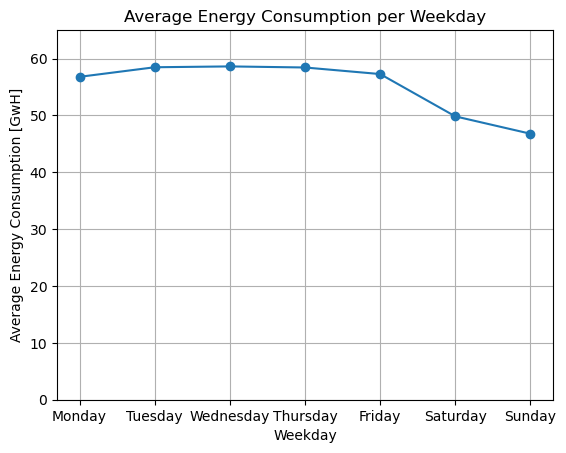

In [61]:
# plot average energy consumption throughout week 

energy_data_per_weekday = energy_data.groupby(by='weekday')['energy_consumption'].mean()
energy_data_per_weekday = energy_data_per_weekday.to_frame().reset_index()

# define the weekdays
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create bar plot
plt.plot(weekdays,energy_data_per_weekday.loc[:,
         'energy_consumption'], marker='o', linestyle='-')
plt.xlabel('Weekday')
plt.ylabel('Average Energy Consumption [GwH]')
plt.title('Average Energy Consumption per Weekday')
plt.grid(True)  # Add grid lines
plt.ylim(0, 65)
plt.show()

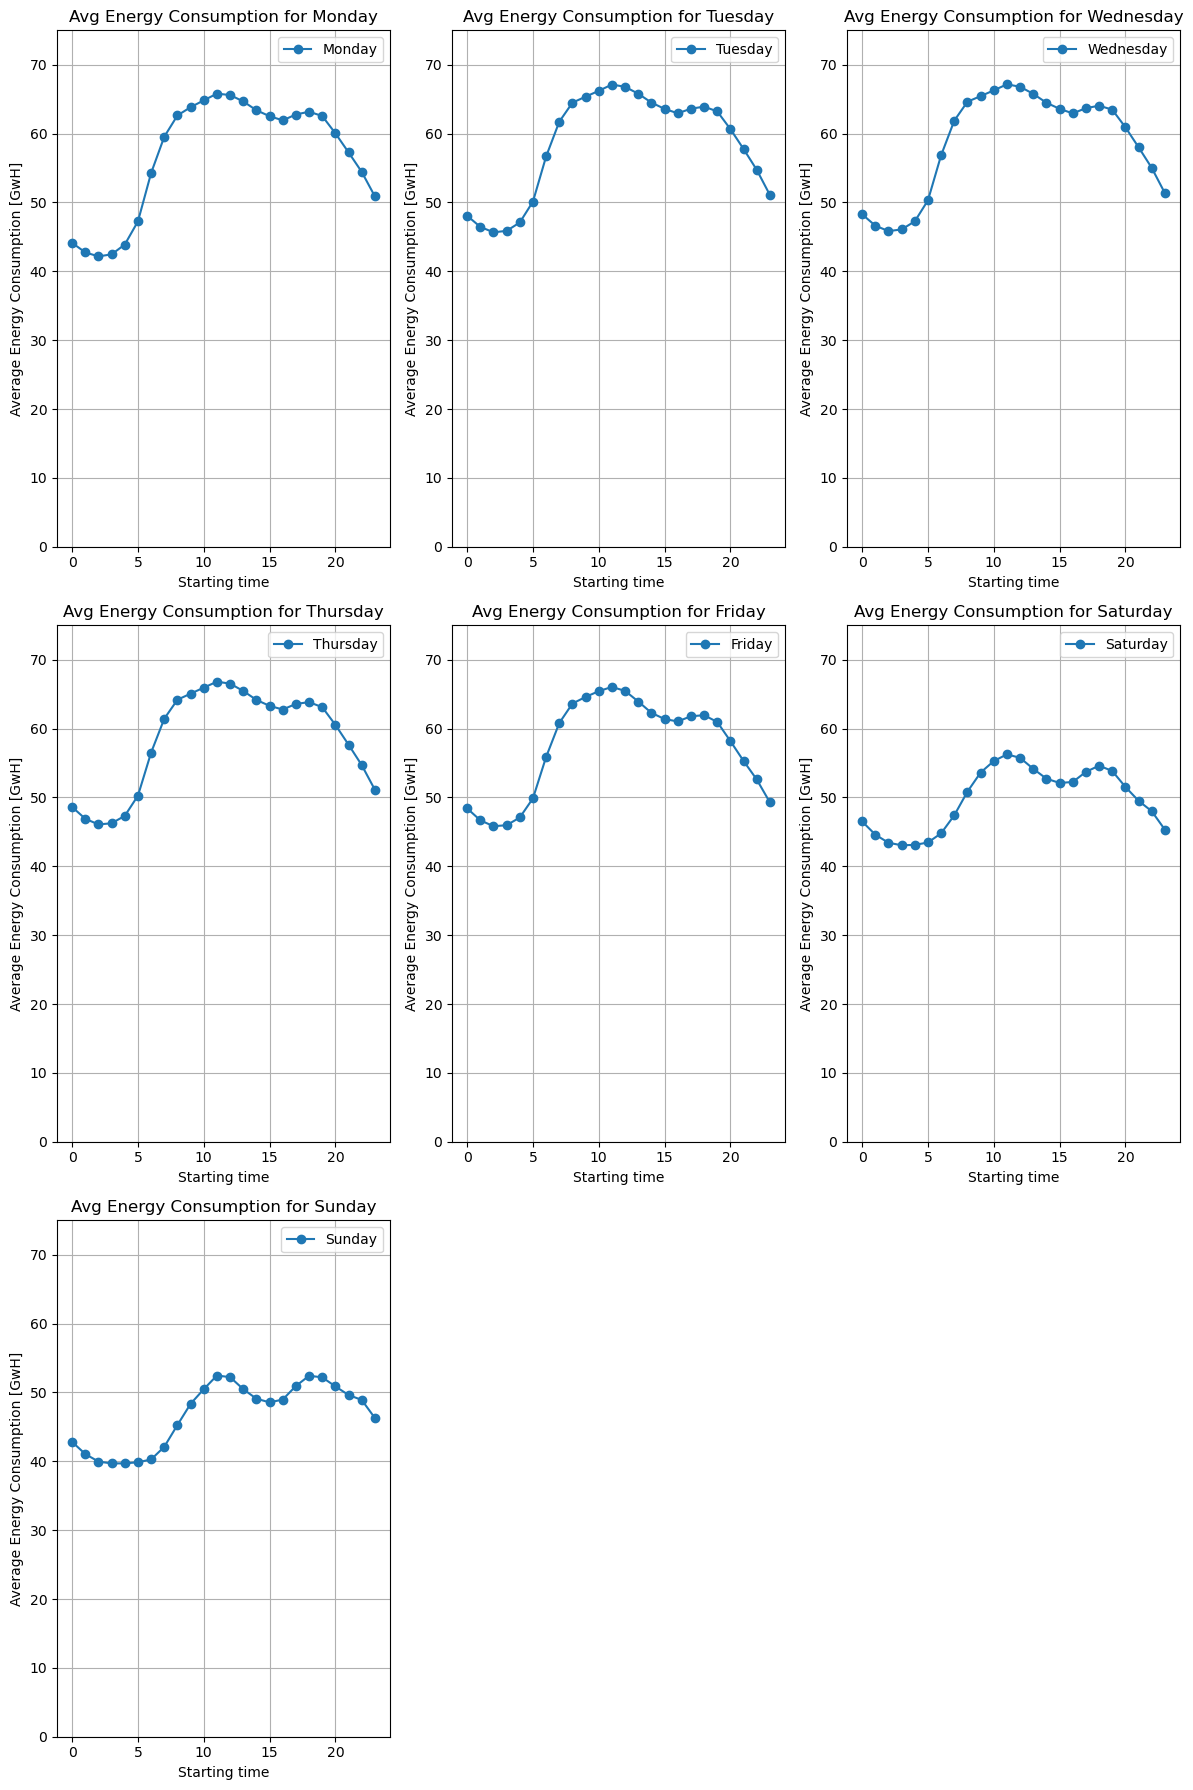

In [69]:
energy_data_per_day_hour_and_weekday = energy_data.groupby(
    ['weekday', 'hour'])['energy_consumption'].mean().unstack()

# Create subplots with two or three plots in a row
num_weekdays = len(weekdays)
num_plots_per_row = 3
num_rows = (num_weekdays + num_plots_per_row - 1) // num_plots_per_row

# Set the figure size based on the number of rows and plots per row
fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(12, 6*num_rows))

for day, ax in zip(range(num_weekdays), axes.flatten()):
    ax.plot(hours, energy_data_per_day_hour_and_weekday.loc[day, :],
            marker='o', linestyle='-', label=weekdays[day])
    ax.set_xlabel('Starting time')
    ax.set_ylabel('Average Energy Consumption [GwH]')
    ax.set_title(f'Avg Energy Consumption for {weekdays[day]}')
    ax.grid(True)
    ax.set_ylim(0, 75)
    ax.legend()

# Hide any empty subplots
for i in range(num_weekdays, num_rows * num_plots_per_row):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()  # Adjust subplot spacing
plt.show()

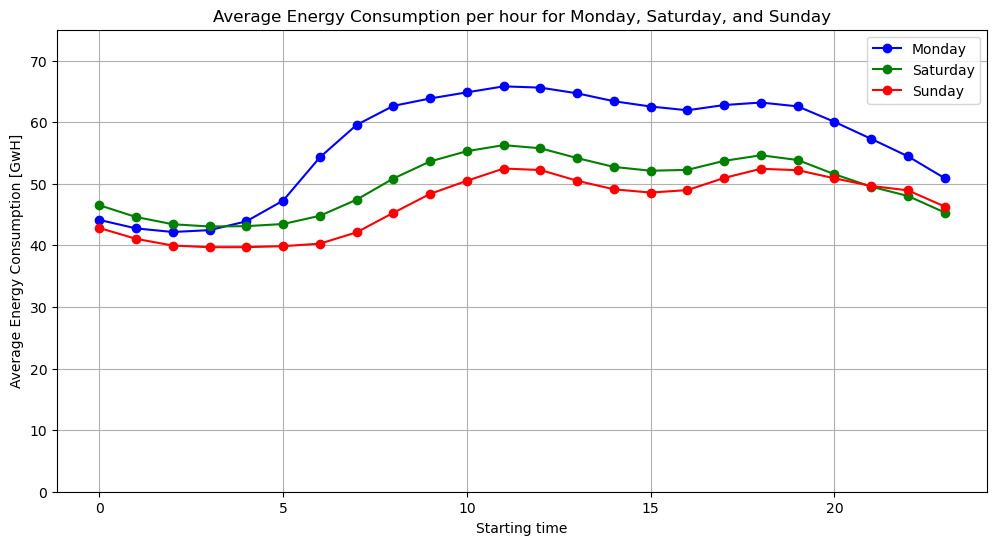

In [74]:
selected_weekdays = ['Monday', 'Saturday', 'Sunday']
colors = ['b', 'g', 'r']  # Colors for Monday, Saturday, and Sunday

plt.figure(figsize=(12, 6))

for day, color in zip(selected_weekdays, colors):
    day_index = weekdays.index(day)
    plt.plot(hours, energy_data_per_day_hour_and_weekday.loc[day_index, :],
             marker='o', linestyle='-', label=day, color=color)

plt.xlabel('Starting time')
plt.ylabel('Average Energy Consumption [GwH]')
plt.title('Average Energy Consumption per hour for Monday, Saturday, and Sunday')
plt.grid(True)
plt.ylim(0, 75)
plt.legend()
plt.show()

# Model 1
baseline model: seasonal linear regression model with dummies for hours and months

In [157]:
# Create dummy variables for month and hour to represent the seasonal components
energy_data1 = pd.get_dummies(
    energy_data, columns=['month', 'hour'], prefix=['month', 'hour'], dtype=int)

# Drop 'smoothed', 'date', 'beginning', 'end' columns
energy_data1 = energy_data1.drop(columns=['date','beginning','end'])

In [162]:
# Define the dependent variable (target) and independent variables (features)
y_mod1 = energy_data1['energy_consumption']
X_mod1 = energy_data1.drop(columns=['energy_consumption', 'weekday'])

# Add a constant for the intercept term
X_mod1 = sm.add_constant(X_mod1)

# Fit the seasonal linear regression model
model1 = sm.OLS(y_mod1, X_mod1).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     energy_consumption   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     1060.
Date:                Wed, 08 Nov 2023   Prob (F-statistic):               0.00
Time:                        10:54:51   Log-Likelihood:                -85596.
No. Observations:               26291   AIC:                         1.713e+05
Df Residuals:                   26256   BIC:                         1.715e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.711e+12   5.91e+12      0.458      0.647   -8.88e+12    1.43e+13
month_1    -1.905e+12   3.23e+12     -0.589      0.556   -8.24e+12    4.43e+12
month_2    -1.905e+12   3.23e+12     -0.589      0.556   -8.24e+12    4.43e+12
month_3    -1.905e+12   3.23e+12     -0.589      0.556   -8.24e+12    4.43e+12
month_4    -1.905e+12   3.23e+12     -0.589      0.556   -8.24e+12    4.43e+12
month_5    -1.905e+12   3.23e+12     -0.589      0.556   -8.24e+12    4.43e+12
month_6    -1.905e+12   3.23e+12     -0.589      0.556   -8.24e+12    4.43e+12
month_7    -1.905e+12   3.23e+12     -0.589      0.556   -8.24e+12    4.43e+12
month_8    -1.905e+12   3.23e+12     -0.589      0.556   -8.24e+12    4.43e+12
month_9    -1.905e+12   3.23e+12     -0.589      0.556   -8.24e+12    4.43e+12
month_10   -1.905e+12   3.23e+12     -0.589      0.556   -8.24e+12    4.43e+12
month_11   -1.905e+12   3.23e+12     -0.589      0.556   -8.24e+12    4.43e+12
month_12   -1.905e+12   3.23e+12     -0.589      0.556   -8.24e+12    4.43e+12
hour_0      -8.06e+11   6.31e+12     -0.128      0.898   -1.32e+13    1.16e+13
hour_1      -8.06e+11   6.31e+12     -0.128      0.898   -1.32e+13    1.16e+13
hour_2      -8.06e+11   6.31e+12     -0.128      0.898   -1.32e+13    1.16e+13
hour_3      -8.06e+11   6.31e+12     -0.128      0.898   -1.32e+13    1.16e+13
hour_4      -8.06e+11   6.31e+12     -0.128      0.898   -1.32e+13    1.16e+13
hour_5      -8.06e+11   6.31e+12     -0.128      0.898   -1.32e+13    1.16e+13
hour_6      -8.06e+11   6.31e+12     -0.128      0.898   -1.32e+13    1.16e+13
hour_7      -8.06e+11   6.31e+12     -0.128      0.898   -1.32e+13    1.16e+13
hour_8      -8.06e+11   6.31e+12     -0.128      0.898   -1.32e+13    1.16e+13
hour_9      -8.06e+11   6.31e+12     -0.128      0.898   -1.32e+13    1.16e+13
hour_10     -8.06e+11   6.31e+12     -0.128      0.898   -1.32e+13    1.16e+13
hour_11     -8.06e+11   6.31e+12     -0.128      0.898   -1.32e+13    1.16e+13
hour_12     -8.06e+11   6.31e+12     -0.128      0.898   -1.32e+13    1.16e+13
hour_13     -8.06e+11   6.31e+12     -0.128      0.898   -1.32e+13    1.16e+13
hour_14     -8.06e+11   6.31e+12     -0.128      0.898   -1.32e+13    1.16e+13
hour_15     -8.06e+11   6.31e+12     -0.128      0.898   -1.32e+13    1.16e+13
hour_16     -8.06e+11   6.31e+12     -0.128      0.898   -1.32e+13    1.16e+13
hour_17     -8.06e+11   6.31e+12     -0.128      0.898   -1.32e+13    1.16e+13
hour_18     -8.06e+11   6.31e+12     -0.128      0.898   -1.32e+13    1.16e+13
hour_19     -8.06e+11   6.31e+12     -0.128      0.898   -1.32e+13    1.16e+13
hour_20     -8.06e+11   6.31e+12     -0.128      0.898   -1.32e+13    1.16e+13
hour_21     -8.06e+11   6.31e+12     -0.128      0.898   -1.32e+13    1.16e+13
hour_22     -8.06e+11   6.31e+12     -0.128      0.898   -1.32e+13    1.16e+13
ho

# Model 2 
## Reduce number of dummy variables 
* aggregate months to seasons 
* aggregate hours to daily timeframes

In [163]:
# Define the mapping of months to seasons
season_mapping = {
    'winter': [12, 1, 2],
    'spring': [3, 4, 5],
    'summer': [6, 7, 8],
    'autumn': [9, 10, 11]
}

# create season dummy variable
for season, months in season_mapping.items():
    energy_data[season] = energy_data['month'].apply(
        lambda x: 1 if x in months else 0)


# Define mapping of hours to timeframes (based on graph)
time_mapping = {
    'low_consumption_time': list(range(7)), # differs a lot weekend/weekday
    'high_consumption_time':list(range(7,20)),
    'transition_time':[6,20,21,22,23]} 

# create timeframe dummy variable
for timeframe, hours in time_mapping.items():
    energy_data[timeframe] = energy_data['hour'].apply(
        lambda x: 1 if x in hours else 0)
    
energy_data2 = energy_data.loc[:,['energy_consumption','winter', 'spring',
                               'summer','autumn','low_consumption_time',
                                'high_consumption_time', 'transition_time']]

## Train model 2 

In [166]:
# Define the dependent variable (target) and independent variables (features)
y_mod2 = energy_data2['energy_consumption']
X_mod2 = energy_data2.drop(columns=['energy_consumption'])

# Add a constant for the intercept term
X_mod2 = sm.add_constant(X_mod2)

# Fit the seasonal linear regression model
model2 = sm.OLS(y_mod2, X_mod2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     energy_consumption   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     4484.
Date:                Wed, 08 Nov 2023   Prob (F-statistic):               0.00
Time:                        10:56:08   Log-Likelihood:                -87690.
No. Observations:               26291   AIC:                         1.754e+05
Df Residuals:                   26284   BIC:                         1.755e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -4.457e+11   8.37e+12     -0.053      0.958   -1.68e+13     1.6e+13
winter                 4.457e+11   8.37e+12      0.053      0.958    -1.6e+13    1.68e+13
spring                 4.457e+11   8.37e+12      0.053      0.958    -1.6e+13    1.68e+13
summer                 4.457e+11   8.37e+12      0.053      0.958    -1.6e+13    1.68e+13
autumn                 4.457e+11   8.37e+12      0.053      0.958    -1.6e+13    1.68e+13
low_consumption_time     -1.4565      0.230     -6.340      0.000      -1.907      -1.006
high_consumption_time    13.5155      0.251     53.808      0.000      13.023      14.008
transition_time           6.7773      0.222     30.535      0.000       6.342       7.212
==============================================================================
Omnibus:                      925.841   Durbin-Watson:                   0.134
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1026.312
Skew:                          -0.483   Prob(JB):                    1.38e-223
Kurtosis:                       2.946   Cond. No.                     5.80e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.32e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Conclusion

Performs way worse than other model (comparing R^2)

# Model 3 

Combination of baseline model (model1) and split of weekdays/weekend 

In [175]:
# split dataframe in weekdays and weekend days
weekday_data = energy_data1.loc[energy_data1['weekday']<6,:]
weekday_data = weekday_data.drop(columns='weekday')

weekend_data = energy_data1.loc[energy_data1['weekday'] >=6,:]
weekend_data = weekend_data.drop(columns='weekday')

# perform each regression separately 

# weekday
y_wd = weekday_data['energy_consumption']
X_wd = weekday_data.drop(columns=['energy_consumption'])

# Add a constant for the intercept term
X_wd = sm.add_constant(X_wd)

# Fit the seasonal linear regression model
model_wd = sm.OLS(y_wd,X_wd ).fit()
print(model_wd.summary())

# weekend
y_we = weekend_data['energy_consumption']
X_we = weekend_data.drop(columns=['energy_consumption'])

# Add a constant for the intercept term
X_we = sm.add_constant(X_we)

# Fit the seasonal linear regression model
model_we = sm.OLS(y_we, X_we).fit()
print(model_we.summary())

                            OLS Regression Results                            
Dep. Variable:     energy_consumption   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     1400.
Date:                Wed, 08 Nov 2023   Prob (F-statistic):               0.00
Time:                        10:59:22   Log-Likelihood:                -69598.
No. Observations:               22523   AIC:                         1.393e+05
Df Residuals:                   22488   BIC:                         1.395e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.701e+13   7.68e+12      3.520      0.0

# Predict future values with model 3
Required: 
* Friday, 12:00, 16:00 and 20:00.
* Three hours starting on Saturday, 12:00, 16:00 and 20:00
tau = [.025, .25, .5, .75, .975]

In [216]:
# create new dataframe containing future date_times and indepentent variables
last_ts = energy_data.index[-1]
horizon = pd.date_range(start=last_ts + pd.DateOffset(
    hours=1), periods=200, freq='H')

energy_forecast = pd.DataFrame({'date_time': horizon})
energy_forecast.set_index('date_time', inplace=True)
energy_forecast['weekday'] = energy_forecast.index.weekday  # monday = 0, sunday = 6
energy_forecast['hour'] = energy_forecast.index.hour
energy_forecast['month'] = energy_forecast.index.month

energy_forecast = pd.get_dummies(
    energy_forecast, columns=['month', 'hour'], prefix=['month', 'hour'], dtype=int)

# add dummies of months not contained in energy_forecast
missing_columns = set(energy_data1.columns) - set(energy_forecast.columns)
for col in missing_columns:
    energy_forecast[col] = 0

# Point forecasts
X_fc = energy_forecast.drop(columns=['weekday'])
X_fc = sm.add_constant(X_fc)

# Make predictions
predictions = model1.predict(X_fc)

# safe in energy_forecast 
energy_forecast['point forecast'] = predictions
energy_data1

,energy_consumption,weekday,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
date_time,,,,,,,,,,,,,,,,,,,,,
2020-11-07 00:00:00,46.97475,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-11-07 01:00:00,45.35550,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-11-07 02:00:00,44.66450,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-11-07 03:00:00,44.76300,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-11-07 04:00:00,44.81150,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-07 06:00:00,59.43725,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-11-07 07:00:00,63.89000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-11-07 08:00:00,66.64725,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Import data 
To-do: 
* via URL
* If date, beginning and ending columns unnecessary --> delete 

In [86]:

# import data 
energy_data = (pd.read_csv('hourly_ec_20201107_20231107.csv',
                 delimiter=';', encoding='utf-8')
               .iloc[:, 0:4]
               .dropna()
               .rename(columns={'Datum': 'date', 
                                        'Anfang': 'beginning', 
                                        'Ende': 'end', 
                                        'Gesamt (Netzlast) [MWh] Berechnete Auflösungen': 'energy_consumption'}))


# convert data type and measurement unit of energy consumption (in GWh instead of MWh)
energy_data = energy_data[~energy_data['energy_consumption'].str.contains('-')]  
energy_data['energy_consumption'] = (energy_data['energy_consumption'].str.replace('.', '', regex=False)
                                                                    .str.replace(',', '.', regex=False)
                                                                    .astype(float) / 1000)

# Set date_time as row index for time series 
energy_data['date'] = pd.to_datetime(energy_data['date'], format='%d.%m.%Y')
energy_data['beginning'] = pd.to_datetime(
    energy_data['beginning'], format='%H:%M').dt.time
energy_data['end'] = pd.to_datetime(
    energy_data['end'], format='%H:%M').dt.time
energy_data['date_time'] = energy_data.apply(
                                           lambda row: pd.Timestamp.combine(row['date'], row['beginning']), axis=1)
energy_data.set_index('date_time', inplace=True)

# check
energy_data.head(30)
energy_data.tail(30)
#energy_data.dtypes

,date,beginning,end,energy_consumption
date_time,,,,
2023-11-06 05:00:00,2023-11-06,05:00:00,06:00:00,49.12350
2023-11-06 06:00:00,2023-11-06,06:00:00,07:00:00,58.11750
2023-11-06 07:00:00,2023-11-06,07:00:00,08:00:00,63.23550
2023-11-06 08:00:00,2023-11-06,08:00:00,09:00:00,66.24100
2023-11-06 09:00:00,2023-11-06,09:00:00,10:00:00,67.21525
2023-11-06 10:00:00,2023-11-06,10:00:00,11:00:00,67.49250
2023-11-06 11:00:00,2023-11-06,11:00:00,12:00:00,68.75700
2023-11-06 12:00:00,2023-11-06,12:00:00,13:00:00,67.61500
2023-11-06 13:00:00,2023-11-06,13:00:00,14:00:00,67.16450


In [ ]:
# Unneccessary code 
# energy_data['Beginning'] = energy_data['Beginning'].str.split(
#    ':').str[0].astype(int)
# energy_data['End'] = energy_data['End'].str.split(
#    ':').str[0].astype(int)